In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import zipfile
import requests
import io

# Step 1: Download & Load MovieLens Dataset
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
ratings = pd.read_csv(z.open("ml-latest-small/ratings.csv"))
movies = pd.read_csv(z.open("ml-latest-small/movies.csv"))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.shape

(100836, 4)

In [ ]:
movies.shape

(9742, 3)

In [ ]:
user_item_matrix = ratings.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index = user_item_matrix.columns, columns = user_item_matrix.columns)
print(item_similarity_df.head())

movieId    1         2         3         4         5         6         7       \
movieId                                                                         
1        1.000000  0.410562  0.296917  0.035573  0.308762  0.376316  0.277491   
2        0.410562  1.000000  0.282438  0.106415  0.287795  0.297009  0.228576   
3        0.296917  0.282438  1.000000  0.092406  0.417802  0.284257  0.402831   
4        0.035573  0.106415  0.092406  1.000000  0.188376  0.089685  0.275035   
5        0.308762  0.287795  0.417802  0.188376  1.000000  0.298969  0.474002   

movieId    8         9         10      ...  193565  193567  193571  193573  \
movieId                                ...                                   
1        0.131629  0.232586  0.395573  ...     0.0     0.0     0.0     0.0   
2        0.172498  0.044835  0.417693  ...     0.0     0.0     0.0     0.0   
3        0.313434  0.304840  0.242954  ...     0.0     0.0     0.0     0.0   
4        0.158022  0.000000  0.095598  ...

In [32]:
def recommend_items(user_id, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    scores = np.dot(user_ratings, item_similarity)
    scores_df = pd.Series(scores, index=user_item_matrix.columns)

    # Remove movies the user already rated
    already_rated = user_ratings[user_ratings > 0].index
    scores_df = scores_df.drop(already_rated)

    # Map movieId → movie title
    recommended_ids = scores_df.sort_values(ascending=False).head(top_n).index
    return movies[movies['movieId'].isin(recommended_ids)]

# Example: Recommend for user 5
print("\nRecommended movies for user 5:")
print(recommend_items(10))

#


Recommended movies for user 5:
      movieId                                              title  \
3614     4963                              Ocean's Eleven (2001)   
4427     6539  Pirates of the Caribbean: The Curse of the Bla...   
5938    34162                            Wedding Crashers (2005)   
6062    40815         Harry Potter and the Goblet of Fire (2005)   
7043    69122                               Hangover, The (2009)   

                               genres  
3614                   Crime|Thriller  
4427  Action|Adventure|Comedy|Fantasy  
5938                   Comedy|Romance  
6062  Adventure|Fantasy|Thriller|IMAX  
7043                     Comedy|Crime  


In [33]:
recommendation_counts = {}
for user in ratings['userId'].unique()[:30]:  # sample 30 users
    recs = recommend_items(user, top_n=5)['movieId'].values
    for r in recs:
        recommendation_counts[r] = recommendation_counts.get(r, 0) + 1

rec_stats = pd.DataFrame(list(recommendation_counts.items()), columns = ['movieId', 'count']).sort_values(by = 'count', ascending = False)
rec_stats = rec_stats.merge(movies, on = 'movieId')
print(rec_stats.head())

   movieId  count                                              title  \
0     1196      7  Star Wars: Episode V - The Empire Strikes Back...   
1     2918      5                    Ferris Bueller's Day Off (1986)   
2     1210      5  Star Wars: Episode VI - Return of the Jedi (1983)   
3     1265      5                               Groundhog Day (1993)   
4     2115      4        Indiana Jones and the Temple of Doom (1984)   

                     genres  
0   Action|Adventure|Sci-Fi  
1                    Comedy  
2   Action|Adventure|Sci-Fi  
3    Comedy|Fantasy|Romance  
4  Action|Adventure|Fantasy  


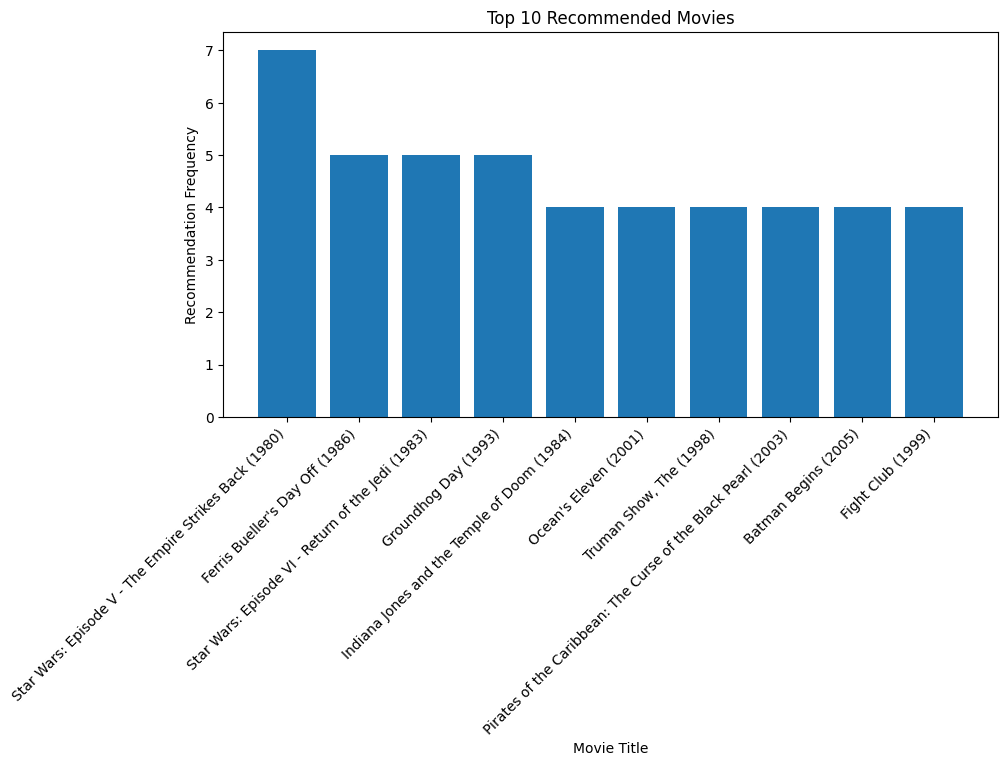

In [34]:
# Plot top recommended movies
plt.figure(figsize=(10,5))
plt.bar(rec_stats['title'].head(10), rec_stats['count'].head(10))
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Recommended Movies")
plt.xlabel("Movie Title")
plt.ylabel("Recommendation Frequency")
plt.show()